<a href="https://colab.research.google.com/github/CarlosRochaCx/MNA/blob/main/MNA_IAyAA_Actividad_Semana_5_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Maestría en Inteligencia Artificial Aplicada**

## **Curso: Inteligencia Artificial y Aprendizaje Automático**

Tecnológico de Monterrey

Prof Luis Eduardo Falcón Morales

**Actividad de la Semana 5**

### **Modelos basados en Árboles**



**Nombres y matrículas de los integrantes del Equipo:**

*   Carlos Alberto Rocha Chávez - A01796914
*   Nombre y matrícula
*   Nombre y matrícula



# **PARTE - 1 - Bosque Aleatorio (Random Forest) - Clasificación**

In [33]:
# Importamos lo necesario para la actividad

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, RandomizedSearchCV, learning_curve, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.metrics import make_scorer, recall_score, accuracy_score, precision_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier

from imblearn.pipeline import Pipeline  # Observa que usamos imblearn.Pipeline en lugar de sklearn
from imblearn.over_sampling import SMOTE

# Semilla para reproducibilidad
np.random.seed(17)

In [34]:
# Para esta actividad vamos a generar datos sintéticos para un problema de
# clasificación binario utilizando "make_classification" de sklearn.

# Recuerda consultar la documentación para mayor información:
# https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html

# Utilizaremos los siguientes calores de los hiperparámetros de make_classification:
# - n_samples: número de muestras (10,000)
# - n_features: número total de características (20)
# - n_informative: número de características informativas (14)
# - n_redundant: número de características redundantes (6) .. .incluímos algunas redundantes
# - weights: pesos para las clases [0,1]-->[0.9, 0.1] para conseguir el desbalance 90%-10%
# - class_sep: separación entre clases (mayor valor --> clases más separables y menos complejo)
# - flip_y: fracción de ejemplos cuya clase se cambia aleatoriamente (ruido), para hacerlo más complejo
# - random_state: semilla para reproducibilidad

X, y = make_classification(
    n_samples=10_000,          # 10,000 registros
    n_features=20,             # 20 factores en total
    n_informative=14,          # 14 factores informativos
    n_redundant=6,             # 6 factores redundantes (dependientes)
    weights=[0.9, 0.1],        # Desbalance de clases: 90% clase 0, 10% clase 1
    class_sep=1.0,             # Separación entre clases
    n_classes=2,               # Dos clases
    n_clusters_per_class=1,    # Si queremos agregar complejidad adicional > 1
    flip_y=0.03,               # Añadir algo de ruido. default 0.01
    random_state=17,
)

In [35]:
# Por el momento generaremos un conjunto de dato que supondremos ya
# están escalados y todos las variables son numéricas, para concentrarnos
# en el modelo de Bosque Aleatrorio.

# Escalamos las características para que estén en el mismo rango:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Creamos un DataFrame para su mejor manejo
feature_names = [f'feature_{i+1}' for i in range(20)]
df = pd.DataFrame(X_scaled, columns=feature_names)
df['target'] = y

print(f"Total de registros generados: {len(df)}")
print(f"Distribución de clases: {df['target'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'}")
print(f"Cantidad de features: {len(feature_names)}")

Total de registros generados: 10000
Distribución de clases: target
0    88.9%
1    11.1%
Name: proportion, dtype: object
Cantidad de features: 20


In [36]:
pd.DataFrame(df).describe().T   # Observamos que todos los factores varían en el mismo
                                # rango de aproximadamente -4 y 4.

,count,mean,std,min,25%,50%,75%,max
feature_1,10000.0,2.314948e-15,1.000050,-4.649097,-0.633377,0.035887,0.677096,3.913299
feature_2,10000.0,5.332623e-16,1.000050,-3.797292,-0.667241,0.012047,0.671898,3.658035
feature_3,10000.0,2.275868e-15,1.000050,-3.171984,-0.679866,0.006216,0.671532,4.208274
feature_4,10000.0,8.643752e-16,1.000050,-3.458223,-0.682357,-0.011411,0.677787,3.485939
feature_5,10000.0,2.057732e-15,1.000050,-3.822539,-0.669778,-0.007754,0.668929,3.842924
feature_6,10000.0,9.293899e-16,1.000050,-3.907304,-0.680717,0.003414,0.669981,3.781757
feature_7,10000.0,-1.179501e-16,1.000050,-3.550818,-0.687698,-0.002940,0.665087,3.459775
feature_8,10000.0,1.623945e-15,1.000050,-4.628708,-0.669709,0.003945,0.669659,4.161228
feature_9,10000.0,-2.810907e-15,1.000050,-3.921339,-0.676168,0.012378,0.676704,3.764050
feature_10,10000.0,1.605471e-15,1.000050,-3.611846,-0.690308,-0.006640,0.672674,4.104303


In [37]:
# Separamos las variables de entrada y la variable objetivo de salida:
X = df.drop('target', axis=1).values
y = df['target'].values

# Dividir el conjunto de datos en entrenamiento (80%) y prueba (20%)
# Como vamos a utilizar Validación Cruzada, haremos la partición
# en Entrenamiento y Prueba.
# Además usamos s"tratify" para mantener la proporción de clases en la partición.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17, stratify=y)

print(f"Tamaño del conjunto de entrenamiento: {X_train.shape[0]} muestras")
print(f"Tamaño del conjunto de prueba: {X_test.shape[0]} muestras")

Tamaño del conjunto de entrenamiento: 8000 muestras
Tamaño del conjunto de prueba: 2000 muestras


In [38]:
# Hagamos esta partición temporal para tener un valor aproximado del desempeño
# mínimo que alcanzará nuestro modelo más simple.
Xt, Xv, yt, yv = train_test_split(X_train, y_train, test_size=0.2, random_state=17, stratify=y_train)

estrategias = ['most_frequent','prior','stratified','uniform']

for estrategia in estrategias:
  dummy_clf = DummyClassifier(strategy=estrategia, random_state=17)
  dummy_clf.fit(Xt, yt)
  y_pred = dummy_clf.predict(Xv)

  # Tabla para almacenar resultados
  results = []

  # "pos_label" indica la clase con respecto a la cual evaluar cada métrica.
  acc = accuracy_score(yv, y_pred)
  rec = recall_score(yv, y_pred, pos_label=1)
  prec = precision_score(yv, y_pred, pos_label=1)
  f1_sc = f1_score(yv, y_pred, pos_label=1)

  results.append({'Accuracy': acc,
                'Recall': rec,
                'Precision': prec,
                'F1 Score': f1_sc
                })
  print(f"Estrategia: {estrategia}")
  print(f"Accuracy: {acc:.4f}")
  print(f"Recall: {rec:.4f}")
  print(f"Precision: {prec:.4f}")
  print(f"F1 Score: {f1_sc:.4f}")
  print()

Estrategia: most_frequent
Accuracy: 0.8888
Recall: 0.0000
Precision: 0.0000
F1 Score: 0.0000

Estrategia: prior
Accuracy: 0.8888
Recall: 0.0000
Precision: 0.0000
F1 Score: 0.0000

Estrategia: stratified
Accuracy: 0.8163
Recall: 0.0787
Precision: 0.0972
F1 Score: 0.0870

Estrategia: uniform
Accuracy: 0.4825
Recall: 0.4494
Precision: 0.0988
F1 Score: 0.1619



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## **Ejercicio - 1**

### **En este ejercicio deseamos obtener el umbral del desempeño mínimo que debiera alcanzar nuestro modelo, es decir, obtener el desempeño del modelo más simple (dummy). Consideraremos las siguientes políticas de la función DummyClassifier(): "most_frequent", "prior, "stratified" y "uniform".**

Recuerda revisar la documentación correspondiente:

https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html

### **Ejercicio 1a**

#### **Para los casos "most_frequent" y "prior" observamos que se obtiene un "UndefinedMetricWarning" y nos dice que la métrica Precision no está bien definida ("ill-defined") ¿Qué significa este aviso? ¿Y si usamos la fórmula de Precision, qué nos resultaría?**

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Incluye aquí tus comentarios.

Lo que este warning nos indica es que nuestro modelo no clasificó ninguna muestra como positiva, es decir, el modelo nunca predijo la clase 1, la cual es la clase minoritaria. Debido a esto, la precisión no puede ser calculada, ya que imiplicaría una división por cero.

Si aplicamos la fórmula de la precisión (Precisión = VP / VP + FP), tanto "most_frequent" como "prior" darían un valor de cero, ya que ambos modelos nunca predicen la clase positiva, por lo que quedaría Precisión = 0 / (0 + 0), lo cuál es matemáticamente imposible.

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

### **Ejercicio 1b**

#### **Supongamos que la métrica que vamos a estar monitoreando es el "F1-score". Si esta fuera nuestra decisión y considerando los valores numéricos obtenidos en la celda anterior, ¿cuál de las cuatro políticas ("most_frequent", "prior, "stratified", "uniform") recomendarías utilizar para obtener el desempeño mínimo que debiera tener nuestro mejor modelo que vamos a construir con RandomForest? Y por lo tanto, ¿cuál sería este valor mínimo? Justifica tu decisión.**

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Incluye aquí tus comentarios.

El f1-score es la media armónica entre precisión y recall, por lo que es útil para situaciones en las que las clases están desbalanceadas, tal y cómo es el caso propuesto en este ejercicio. Al evaluar las cuatro estrategias, elegiríamos ```uniform```, ya que al comparar los resultados obtenidos, esta es la que obtiene el F1-score más alto. Este resultado indica que la estrategia ```uniform``` produce más predicciones positivas al azar, y aunque esto reduzca la exactitud en general, permite que se puedan generar más verdaderos positivos que otros modelos.

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

## **Ejercicio - 2:**

* #### **En lo que resta de esta primera parte de la Actividad, supondremos que la métrica F1-score es la que nos interesa monitorear.**

* #### **Así, a continuación deberás encontrar la mejor configuración del modelo Bosque Aleatorio que te resulte en la mejor métrica F1-score con respecto a la clase positiva 1.**

* #### **Además, el modelo no debe estar sub-entrenado o sobre-entrenado con respecto a esta métrica F1-score.**

* #### **Deberas decidir si se requiere incluir alguna técnica de sub-mestreo y/o sobre-muestro.**

* #### **Incluye los hiperparámetros que consideres adecuados, pero recuerda que si incluyes demasiados, el tiempo de entrenamiento se incrementa.**


Revisa la documentación correspondiente:

* https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

* https://imbalanced-learn.org/stable/references/over_sampling.html

* https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html

Fitting 5 folds for each of 20 candidates, totalling 100 fits

Mejores parámetros encontrados:
 {'smote__k_neighbors': 7, 'model__n_estimators': 100, 'model__min_samples_split': 2, 'model__min_samples_leaf': 1, 'model__max_depth': 20, 'model__class_weight': 'balanced'}




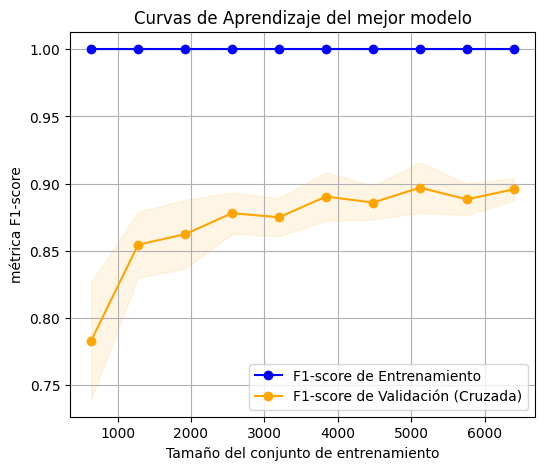

In [39]:
# Ejercicio 2:


# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# +++++++ INICIA SECCIÓN PARA INCLUIR TUS AJUSTES ++++++++++++++++++

# Incluyo algunos ejemplos, pero puedes incluir más si lo deseas, revisa
# la documentación correspondiente.

# Definimos nuestro pipeline:
pipeline = Pipeline([
    ('smote', SMOTE(random_state=17)),
    ('model', RandomForestClassifier(random_state=17))
])

# Definimos los posibles valores para la búsqueda de malla.
# El total de opciones a buscar en esta malla se obtiene con el producto
# de la cantidad de casos de cada hiperparámetro.
# Observa la diferencia entre el guión bajo doble y el sencillo.
param_grid = {
    'smote__k_neighbors': [5,7],  # Descomenta para usar hiperparámetros de la técnica de balanceo.
    #'smote__k_neighbors': [3, 5],
    'model__n_estimators': [50,100],  # Hiperparámetros del modelo ...
    #'model__n_estimators': [100, 200],
    'model__max_depth': [10, 20, None],
    'model__min_samples_split': [2, 5],
    'model__min_samples_leaf': [1, 3],
    'model__class_weight': [None, 'balanced']
}

# Utilizaremos Validación Cruzada Estratificada:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)

# Aquí definimos la métrica a utilizar, en nuestro caso, F1-score:
scorer = make_scorer(f1_score, average='binary', pos_label=1) # Esta línea no la modifiques.

# Conjuntamos todo en la búsqueda de malla GridSearch:
grid_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grid,
    #n_iter=None,   # Aquí indicas el número de opciones del param_grid en los que harás la búsqueda.
    n_iter=20,        # Aquí indicas el número de opciones del param_grid en los que harás la búsqueda.
    cv=cv,
    scoring=scorer,
    n_jobs=-1,
    verbose=1,
    random_state=17 #agregado
)

# +++++++++++++ TERMINA SECCIÓN PARA REALIZAR AJUSTES +++++++++++++++
# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++



# Hacemos el ajuste del modelo con los datos de entrenamiento:
grid_search.fit(X_train, y_train)

# Y evaluamos con el mejor  conjunto de prueba
#best_model = grid_search.best_estimator_
#y_pred = best_model.predict(X_test)

best_params = grid_search.best_params_
print(f"\nMejores parámetros encontrados:\n {best_params}\n\n")




# **************************************************************************
# Gráfico de curvas de aprendizaje del mejor modelo.
best_model = grid_search.best_estimator_

# Definimos tamaños de entrenamiento relativos al conjunto de entrenamiento:
train_sizes = np.linspace(0.1, 1.0, 10)

# Calculamos curvas de aprendizaje con cross-validation:
train_sizes, train_scores, valid_scores = learning_curve(
    estimator=best_model,     # Usamos el mejor modelo encontrado
    X=X_train,
    y=y_train,
    train_sizes=train_sizes,  # Tamaños de entrenamiento a evaluar
    cv=5,
    scoring='f1',             # Métrica a evaluar, en nuetro caso F1-score
    n_jobs=-1,                # Usar todos los núcleos disponibles
    random_state=17
)

# Calculamos medias y desviaciones estándar:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
valid_mean = np.mean(valid_scores, axis=1)
valid_std = np.std(valid_scores, axis=1)


# Área sombreada en el gráfico para la desviación estándar:
plt.figure(figsize=(6, 5))
plt.fill_between(train_sizes, train_mean - train_std,
                 train_mean + train_std, alpha=0.1, color='blue')
plt.fill_between(train_sizes, valid_mean - valid_std,
                 valid_mean + valid_std, alpha=0.1, color='orange')

# Grafcamos el polígono de las medias:
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='F1-score de Entrenamiento')
plt.plot(train_sizes, valid_mean, 'o-', color='orange', label='F1-score de Validación (Cruzada)')


plt.title(f'Curvas de Aprendizaje del mejor modelo')
plt.xlabel('Tamaño del conjunto de entrenamiento')
plt.ylabel('métrica F1-score')
plt.grid(True)
plt.legend(loc='lower right')
#plt.ylim([0.8, 1.01])  # Puedes ajustar el rango del eje Y según tus datos
plt.show()

In [40]:
grid_search   # mejor configuración obtenida

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=True),
                   estimator=Pipeline(steps=[('smote', SMOTE(random_state=17)),
                                             ('model',
                                              RandomForestClassifier(random_state=17))]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'model__class_weight': [None,
                                                                'balanced'],
                                        'model__max_depth': [10, 20, None],
                                        'model__min_samples_leaf': [1, 3],
                                        'model__min_samples_split': [2, 5],
                                        'model__n_estimators': [50, 100],
                                        'smote__k_neighbors': [5, 7]},
                   random_state=17,
                   scoring=make_scorer(f1_score, response_method='predict', average=binary, pos_label=1),
                   verbose=1)

## **Conjunto de Prueba**

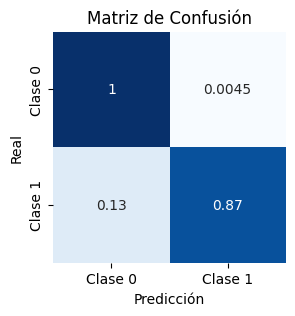

In [41]:
# Pasemos a predecir con el conjunto de Prueba (Test) una vez
# que encontraste tu mejor modelo.

y_pred = best_model.predict(X_test)

# Probabilidades de predicción para la clase 1
y_proba = best_model.predict_proba(X_test)[:, 1]

# Matriz de confusión:
cm = confusion_matrix(y_test, y_pred, normalize='true')
plt.figure(figsize=(3,3))
sns.heatmap(cm, annot=True, fmt='.2g', cmap='Blues', cbar=False)   # en caso de enteros: fmt='d'
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.xticks([0.5, 1.5], ['Clase 0', 'Clase 1'])
plt.yticks([0.5, 1.5], ['Clase 0', 'Clase 1'])
plt.show()

In [42]:
# Reporte de clasificación estándar
print("Reporte de Clasificación Estándar:")
print(classification_report(y_test, y_pred))

Reporte de Clasificación Estándar:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1777
           1       0.96      0.87      0.91       223

    accuracy                           0.98      2000
   macro avg       0.97      0.93      0.95      2000
weighted avg       0.98      0.98      0.98      2000



## **Nuevo umbral de decisión con F1-score**

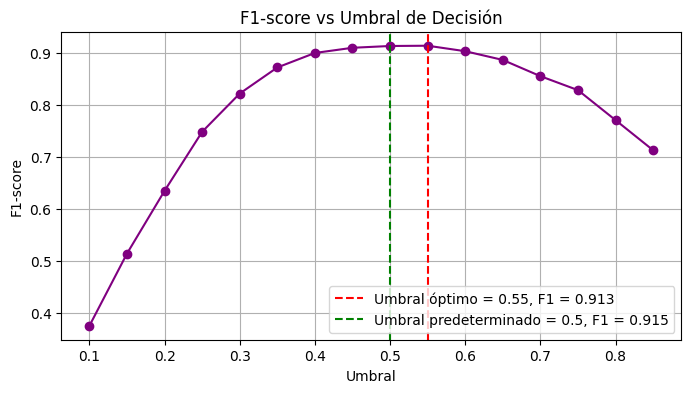

In [43]:
# En problemas desbalanceados, el umbral por defecto de 0.5 puede no ser el óptimo
# para hacer las predicciones:
# Si y_proba>0.5, entonces lo asignamos a la Clase_1, en otro caso, a la Clase_0.

# Vamos a encontrar el umbral que maximiza el F1-score y determinar si sigue
# siendo el valor por defecto.

thresholds = np.arange(0.1, 0.9, 0.05)
f1_scores = []

for threshold in thresholds:
    y_binary = (y_proba >= threshold).astype(int)
    f1 = f1_score(y_test, y_binary)
    f1_scores.append(f1)

# Encontrar el mejor umbral
best_threshold_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_threshold_idx]
best_f1 = f1_scores[best_threshold_idx]

plt.figure(figsize=(8,4))
plt.plot(thresholds, f1_scores, 'o-', color='purple')
plt.axvline(x=best_threshold, color='r', linestyle='--',
            label=f'Umbral óptimo = {best_threshold:.2f}, F1 = {best_f1:.3f}')
plt.axvline(x=0.5, color='g', linestyle='--',
            label=f'Umbral predeterminado = 0.5, F1 = {f1_score(y_test, (y_proba >= 0.5).astype(int)):.3f}')
plt.title('F1-score vs Umbral de Decisión')
plt.xlabel('Umbral')
plt.ylabel('F1-score')
plt.grid(True)
plt.legend()
plt.show()

In [44]:
# Evaluar el modelo con el umbral óptimo
y_pred_optimal = (y_proba >= best_threshold).astype(int)
print("\nResultados con umbral óptimo:")
print(classification_report(y_test, y_pred_optimal))


Resultados con umbral óptimo:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1777
           1       0.98      0.85      0.91       223

    accuracy                           0.98      2000
   macro avg       0.98      0.93      0.95      2000
weighted avg       0.98      0.98      0.98      2000



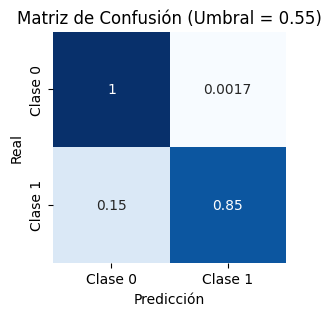

In [45]:
# Matriz de confusión con umbral óptimo
cm_optimal = confusion_matrix(y_test, y_pred_optimal, normalize='true')
plt.figure(figsize=(3,3))
sns.heatmap(cm_optimal, annot=True, fmt='.2g', cmap='Blues', cbar=False)
plt.title(f'Matriz de Confusión (Umbral = {best_threshold:.2f})')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.xticks([0.5, 1.5], ['Clase 0', 'Clase 1'])
plt.yticks([0.5, 1.5], ['Clase 0', 'Clase 1'])
plt.show()

## **Ejercicio - 3**

#### **Con base a los resultados obtenidos responde los siguientes incisos que ayuden a concluir esta primera parte de la actividad.**

* **Ejercicio 3a: Comenta por qué el modelo final que obtuviste no está subentrenado, ni sobreentrenado.**


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Incluye aquí tus comentarios.

Al analizar el rendimiento del modelo, podemos observar que muestra un buen desempeño ante ambas clases, tanto en la mayoritaria como en la minoritaria, por lo que la idea de que el modelo esté subentrenado sería incorrecto, ya que el modelo ha aprendido correctamente la estructura del problema a pesar del desbalance de clases. Además, al realizar la validación cruzada podemos observar que el modelo no está sobreentrenado, ya que si lo fuera, se mostraría una precisión artificialmente alta con un bajo rendimiento en test o validación cruzada.

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

* **Ejercicio 3b: Comenta las diferencias (si las hay) que observas entre usar el umbral predeterminado 0.5 y el nuevo umbral.**


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Incluye aquí tus comentarios.

Las diferencias son mínimas, manteniendo un resultado de F1 y de accuracy idéntico. La única diferencia es que ante el umbral óptimo obtenemos una mejora ligera en la precisión, de 0.96 a 0.98, con una ligera caída en el recall, de 0.87 a 0.85. Sin embargo, el hecho de que ambos tienen el mismo F1-score indica que el balance se mantiene en ambos modelos.

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


* **Ejercicio 3c: Comenta el impacto que viste al usar o no alguna técnica de submuestreo.**


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Incluye aquí tus comentarios.

Podemos observar que el uso de SMOT fue fundamental para optimizar el rendimiento de nuestro modelo para la clase minoritaria, ya que este ayudó a tener un modelo más robusto, balanceado y útil para la tarea de clasificación, a pesar del alto desbalance de los datos. Si no se hubiera usado esta técnica de balanceo, hubiera sido muy probable que el modelo final tuviera un rendimiento malo o engañoso.

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


* **Ejercicio 3d: incluye tus comentarios finales de esta primera parte de la actividad.**

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Incluye aquí tus comentarios.

Con esta primera actividad se pudo desarollar, entrenar y evaluar un modelo de clasificación binaria sobre un conjunto de datos desbalanceado. Ante esta situación se implementaron técnicas de preprocesamiento, balanceo de clases y de optimización de hiperparámetros que nos permitieron desarrollar un modelo bastante confiable y preciso ante la problematica de clasificación presentada inicialmente. El uso de SMOTE permitió que le modelo aprendiera los mejores patrones de la clase minoritaria, evitando que simplemente se predijera siempre la clase mayoritaria. Además de esto, con el uso de GridSearchCV y la validación cruzada se definieron los hiperparámetros que lograron que nuestro modelo fuera más robusto, esto se pudo visualizar claramente al evaluarlo utilizando las métricas más importantes para casos de problemas desbalanceados, tal y como son precision, recall y el f1-score.

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


# **PARTE - 2 - XGBoost - Regressor**

Ver documentación para hiperparámetros del modelo:

https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBRegressor

https://xgboost.readthedocs.io/en/stable/parameter.html

In [46]:
import numpy as np
import pandas as pd

from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_validate
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from xgboost import XGBRegressor
from sklearn.model_selection import learning_curve

import matplotlib.pyplot as plt
import seaborn as sns

# Semilla para reproducibilidad
np.random.seed(17)

In [47]:
# Generamos un dataset de regresión con 10,000 muestras y 20 características
X, y = make_regression(n_samples=10_000,
                       n_features=20,
                       n_informative=15,
                       n_targets=1,
                       noise=100.,
                       random_state=17)

# Convertimos a DataFrame de Pandas:
df = pd.DataFrame(X, columns=[f"feat_{i}" for i in range(X.shape[1])])
df['target'] = y

print("Forma del dataset:", df.shape)


Forma del dataset: (10000, 21)


In [48]:
df.describe().T   # Observa que estos factores ya están en un rango análogo de -4 a 4, aprox.

,count,mean,std,min,25%,50%,75%,max
feat_0,10000.0,0.000608,0.988668,-4.418992,-0.675741,-0.008547,0.666457,3.420933
feat_1,10000.0,-0.020115,0.990471,-4.276634,-0.684205,-0.016707,0.660557,4.268440
feat_2,10000.0,-0.002315,0.997100,-3.937558,-0.666285,-0.003445,0.665691,4.678108
feat_3,10000.0,0.001801,0.999605,-3.439007,-0.675635,0.000741,0.672154,3.367652
feat_4,10000.0,0.009511,0.998881,-4.183096,-0.675305,0.008072,0.688645,3.679313
feat_5,10000.0,0.008578,1.009588,-4.011231,-0.663534,0.010085,0.691533,3.942105
feat_6,10000.0,0.009091,1.003422,-3.685229,-0.659438,0.014835,0.696216,3.856442
feat_7,10000.0,0.013259,1.004526,-3.437249,-0.671930,0.011417,0.700321,4.021915
feat_8,10000.0,-0.013784,0.988581,-3.766905,-0.680303,-0.023345,0.656192,3.649708
feat_9,10000.0,0.020360,0.996445,-3.810134,-0.648353,0.026684,0.688889,3.916547


In [49]:
# División en Train vs Test (80% vs 20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17)

print("Tamaño de entrenamiento:", X_train.shape)
print("Tamaño de test:", X_test.shape)

Tamaño de entrenamiento: (8000, 20)
Tamaño de test: (2000, 20)


## **Ejercicio - 4**

### **Desempeño del modelo base (baseline)**

#### **Las líneas de código de la siguiente celda son un análisis que nos ayudarán posteriormente a determinar si el modelo que obtengamos estará o no subentrenado.**

* **Ejercicio 4a: Explica con tus palabras de manera clara lo que hacen estas líneas de código para poder obtener de ahí el modelo base (baseline) de un modelo de regresión.**


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Incluye aquí tus comentarios.

None

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++



* **Ejercicio 4b: Explica el significado de los valores numéricos mostrados: Valor_1 y Valor_2.**


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Incluye aquí tus comentarios.

None

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

In [50]:
Xt, Xv, yt, yv = train_test_split(X_train, y_train, test_size=0.2, random_state=17)
yt_mean = np.mean(yt)
y_pred_baseline = np.full(shape=yv.shape, fill_value=yt_mean)
rmse_baseline = np.sqrt(mean_squared_error(yv, y_pred_baseline))

print(f"Valor_1-Ejercicio-4b: {yt_mean:.4f}\n")
print(f"Valor_2-Ejercicio-4b: {rmse_baseline:.4f}")

Valor_1-Ejercicio-4b: -1.4395

Valor_2-Ejercicio-4b: 241.5413


## **Ejercicio - 5**

* #### **Encuentra la mejor configuración del modelo XGBoost que te resulte con la métrica RMSE.**

* #### **Además, el modelo no debe estar sub-entrenado o sobre-entrenado.**

* #### **Incluye los hiperparámetros que consideres adecuados, pero recuerda que si incluyes demasiados, el tiempo de entrenamiento se incrementa.**

Fitting 5 folds for each of 30 candidates, totalling 150 fits

RMSE del modelo XGBoost: 107.0699

Resultado-para-el-Ejercicio-6b: 55.7%



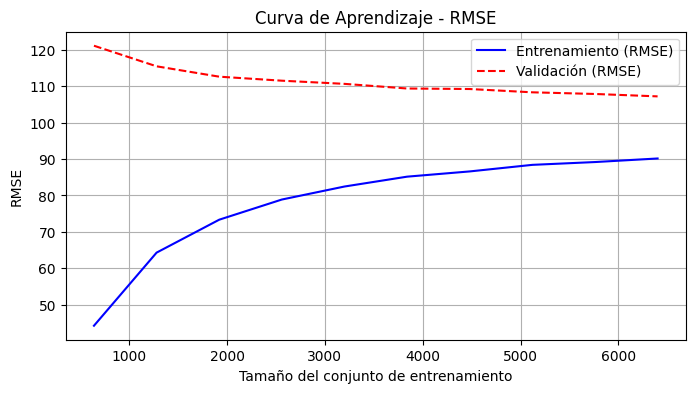

In [51]:
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# +++++++ INICIA SECCIÓN PARA INCLUIR TUS AJUSTES ++++++++++++++++++

# Instanciamos el modelo base:
model = XGBRegressor(random_state=17, n_jobs=-1)

param_grid = {
    'n_estimators': [100, 200],
    #'max_depth': [3, 5], # Incluye aquí todos los casos que desees buscar en la malla.
    'max_depth': [3, 5, 7],
    #'learning_rate': [0.01, 0.1],
    'learning_rate': [0.01, 0.05, 0.1],
    #'subsample': [0.8, 1.0],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 1, 5],
    'reg_alpha': [0, 0.01, 0.1],
    'reg_lambda': [1, 1.5, 2]
}

# Métricas de regresión a evaluar:
scoring = {
    'MAE': 'neg_mean_absolute_error',
    'RMSE': 'neg_root_mean_squared_error',
    'R2': 'r2',
    'MAPE': 'neg_mean_absolute_percentage_error'
}

# Configuración del grid search aleatorio:
grid_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
    n_iter=30,         # Indica la cantidad de casos a buscar en la malla.
    scoring=scoring,
    refit='RMSE',      # Selecciona el mejor modelo según esta métrica RMSE.
    cv=5,
    n_jobs=-1,
    verbose=1,
    random_state=17 #Optional
)

# +++++++++++++ TERMINA SECCIÓN PARA REALIZAR AJUSTES +++++++++++++++
# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++



# Pasamos al entrenamiento del modelo:
grid_search.fit(X_train, y_train)


# **********************************************************************
# Medimos el desempeño del modelo con respecto al modelo base (baseline):
rmse_xgb = -grid_search.best_score_

print(f"\nRMSE del modelo XGBoost: {rmse_xgb:.4f}\n")
print(f"Resultado-para-el-Ejercicio-6b: {(rmse_baseline - rmse_xgb) / rmse_baseline * 100:.1f}%\n")



# ***********************************************************************
# Visualizamos el aprendizaje del mejor modelo:
# Usamos el mejor modelo encontrado por GridSearchCV
best_model = grid_search.best_estimator_

# Definimos los tamaños de entrenamiento a evaluar
train_sizes = np.linspace(0.1, 1.0, 10)

# Calcular las curvas de aprendizaje usando RMSE
train_sizes, train_scores, test_scores = learning_curve(
    estimator=best_model,
    X=X_train,
    y=y_train,
    train_sizes=train_sizes,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    shuffle=True,
    random_state=17
)

# Convertimos los puntajes negativos de RMSE a positivos
train_rmse = -train_scores.mean(axis=1)
test_rmse = -test_scores.mean(axis=1)

plt.figure(figsize=(8,4))
plt.plot(train_sizes, train_rmse, label='Entrenamiento (RMSE)', color='blue')
plt.plot(train_sizes, test_rmse, label='Validación (RMSE)', color='red', linestyle='--')
plt.title('Curva de Aprendizaje - RMSE')
plt.xlabel('Tamaño del conjunto de entrenamiento')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.show()

### **Obtenemos finalmente información con respecto al conjunto de Prueba:**

In [52]:
grid_search   # configuración del mejor modelo encontrado

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0, 1, 5],
                                        'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [3, 5, 7],
                                        'n_estimators': [100, 200],
                                        'reg_alpha': [0, 0.01, 0.1],
                                        'reg_lambda': [1, 1.5, 2],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=17, refit='RMSE',
                   scoring={'MAE': 'neg_mean_absolute_error',
                            'MAPE': 'neg_mean_absolute_percentage_error',
                            'R2': 'r2', 'RMSE': 'neg_root_mean_squared_error'},
                   verbose=1)

In [53]:
# Predicciones en el conjunto de Prueba (Test) con el mejor modelo encontrado:
y_pred = grid_search.predict(X_test)

# Calculamos los valores de las métricas:
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print("\nResultados-para-el-Ejercicio-6c:")
print("\nMétricas en Test:")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")
print(f"MAPE: {mape:.2f}%")


Resultados-para-el-Ejercicio-6c:

Métricas en Test:
MAE: 85.1093
RMSE: 106.6037
R²: 0.8050
MAPE: 228.46%


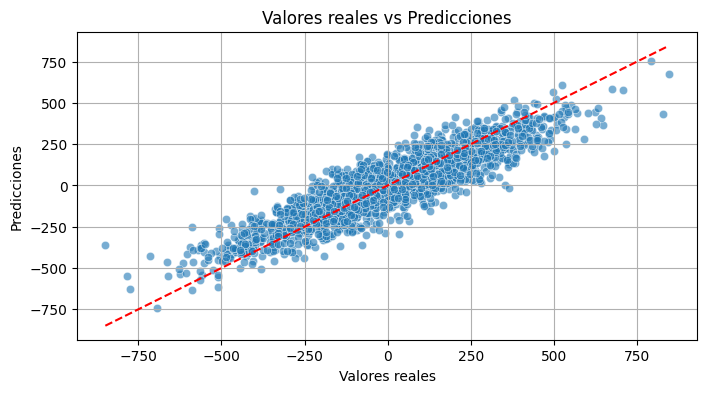

In [54]:
# Gráfico de dispersión entre valores reales y predichos
plt.figure(figsize=(8,4))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
plt.title('Valores reales vs Predicciones')
plt.grid(True)
plt.show()

## **Ejercicio - 6**

#### **Con base a los resultados obtenidos responde los siguientes incisos que ayuden a concluir esta segunda parte de la actividad.**

* **Ejercicio 6a: Comenta por qué el modelo final que obtuviste no está subentrenado, ni sobreentrenado.**


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Incluye aquí tus comentarios.

Tomando como base las métricas obtenidas, podemos confirmar que el modelo final no está subentrenado ni sobreentrenado, ya que al comparar el baseline de RMSE inicial de 241.54 con el RMSE del modelo final de 106.60 se observa una mejora significativa, indicando que el modelo ha logrado identificar patrones útiles dentro de los datos, lo cuál no sucedería con un modelo subentrenado. Por otro lado, al analizar el gráfico se puede identificar que las curvas de RMSE, tanto de entrenamiento como de validación, son cercanas y planas al aumentar el tamaño del conjunto de entrenamiento, lo que indica que el modelo generaliza bien y no está sobreajustado o sobreentrenado.

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


* **Ejercicio 6b: Indica cómo interpretas el valor obtenido en "Resultado-para-el-Ejercicio-6b".**


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Incluye aquí tus comentarios.

Este valor mide la mejora relativa al comparar el desempeño del modelo XGBoost en comparación con el modelo base. El porcentaje de 55.7% indica que el modelo XGBoost reduce el error (RMSE) en un 55.7% en comparación con el modelo base.

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++



* **Ejercicio 6c: Indica cómo interpretas cada uno de los resultados que obtuviste en "Resultados-para-el-Ejercicio-6c".**


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Incluye aquí tus comentarios.

* MAE: 85.1093 - El Error Absoluto Medio (MAE) de 85.1093 indica que en promedio, el modelo se equivoca por 85.1 unidades al predecir el valor de la variable objetivo.

* RMSE: 106.6037 - La Raíz del Error Cuadrático Medio (RMSE) busca penalizar más los errores grandes que el MAE, y con un valor de 106.6 indica que las predicciones que realiza el modelo tienen un error promedio de esta magnitud.

* R²: 0.8050 -El Coeficiente de Determinación (R²) con un valor de 0.8050 indica que el 80.5% de la varianza es explicada por el modelo.

* MAPE: 228.46% - El Error Porcentual Absoluto Medio (MAPE), con un valor de 228.46% indica que en promedio el modelo se equivoca en este porcentaje con respecto al valor real. Sin embargo, cabe mencionar que aunque parezca un valor alto, el MAPE no es confiable en regresión con valores negativos o cercanos a cero.

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

* **Ejercicio 3d: Incluye tus comentarios finales de esta segunda parte de la actividad.**

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Incluye aquí tus comentarios.

El modelo XGBoost entrenado y ajustado durante esta actividad demostró ser una solución efectiva para un problema de regresión con ruido. A través de una buena validación cruzada, una malla eficiente de hiperparámetros y el análisis de curvas de aprendizaje, se logró un modelo con buen equilibrio entre precisión y generalización, lo cual es el objetivo central en este tipo de tareas de Machine Learning.

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

## **Ejercicio - 7**

* **Ejercicio 7: incluye tus comentarios finales de esta actividad.**

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Incluye aquí tus comentarios.

None

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

# **Fin de la Actividad de modelos basados en áboles**